In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
import omero
import scipy.cluster.hierarchy as hchy
from seaborn import clustermap

import pandas as pd
from pandas import Series,DataFrame,read_csv, merge,concat,read_hdf,HDFStore
from omero.gateway import BlitzGateway


%matplotlib nbagg
plt.rcParams['image.cmap']='gray'

#hard coded dirs
dbpath='/home/ubuntu/idr_homes/szleo/features/idr0008-rohn-actinome/screenB/output/'
dataDir='/home/ubuntu/data'
scratchDataDir='/scratch/rohnFeatures'


In [10]:
def buildComposite(st,n,m,smpl=None):
    #nxm shots from st in a grid, as an image
    nr=st.shape[0]
    nc=st.shape[1]
    if smpl==None:
        smpl=st.shape[2]/(n*m)
    res=np.zeros((nr*n,nc*m))
    for i in range(n):
        for j in range(m):
            try:
                res[i*nr:i*nr+nr,j*nc:j*nc+nc]=st[:,:,(i*m+j)*smpl]
            except:
                break
    return res

In [13]:
def getRohnTile(imid,x,y,w,h,chan=0):
#    plateId,x,y,w,h,ti,tf=422,0,0,200,200,50,150
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()

        im = conn.getObject("Image", imid)
        pix=im.getPrimaryPixels()

        z=0;c=chan;
        tile = (x, y, w, h) 
        plane = pix.getTile(theC=c,tile=tile)
    finally:
        conn._closeSession()
    
    return plane

## phenotype clustering

In [2]:
conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
connected = conn.connect()

In [4]:
ofId=4810255
original_file = omero.model.OriginalFileI(ofId, False)

openTable = conn.c.sf.sharedResources().openTable(original_file)
rowCount = openTable.getNumberOfRows()

In [5]:
#table to df

column_names = [col.name for col in openTable.getHeaders()]

black_list = []
column_indices = []
for column_name in column_names:
    if column_name in black_list:
        continue
    column_indices.append(column_names.index(column_name))

table_data = openTable.slice(column_indices, None)
data = []
for index in range(rowCount):
    row_values = [column.values[index] for column in table_data.columns]
    data.append(row_values)
    
dfRhonAnn=DataFrame(data)
dfRhonAnn.columns=column_names


In [6]:

#transforming phenotypes into one hot booleans
BoolCols=[]
PhenLab=[]
for col in dfRhonAnn.columns:
    if ('Phenotype' in col)&~('Term' in col):
        dfRhonAnn['Bool'+col]=~(dfRhonAnn[col] =='')
        BoolCols.append('Bool'+col)
        PhenLab.append(dfRhonAnn[col].unique()[1])

In [7]:
phenMap=dfRhonAnn.groupby('siRNA Pool Name')[BoolCols].sum()>0
phenMap=phenMap[phenMap.sum(axis=1)>0]
phenMap.columns=PhenLab
Z = hchy.linkage(phenMap, 'ward')
Zt = hchy.linkage(phenMap.transpose(), 'ward')


<IPython.core.display.Javascript object>


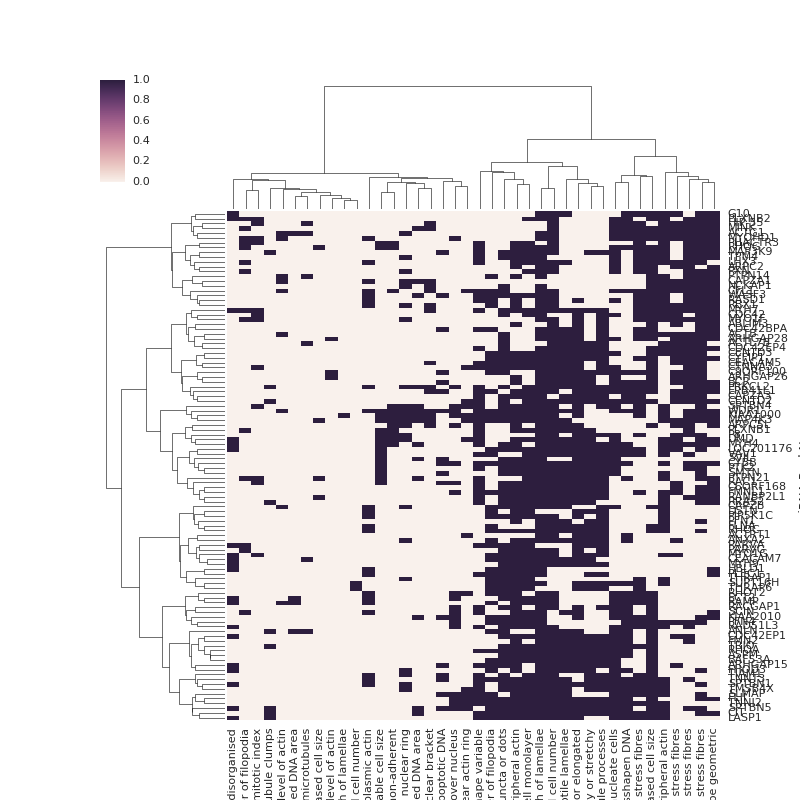

In [8]:
cg=clustermap(phenMap,row_linkage=Z,col_linkage=Zt)
for item in cg.ax_heatmap.get_xticklabels():
    item.set_rotation(90)
for item in cg.ax_heatmap.get_yticklabels():
    item.set_rotation(0)


ERROR:omero.gateway:Failed to close rawPixelsStore
Traceback (most recent call last):
  File "/home/ubuntu/OMERO.server-5.1.4-ice35-b55/lib/python/omero/gateway/__init__.py", line 6458, in getTiles
    rawPixelsStore.close()
  File "/home/ubuntu/OMERO.server-5.1.4-ice35-b55/lib/python/omero/gateway/__init__.py", line 4291, in close
    self._obj.close(*args, **kwargs)
  File "/home/ubuntu/OMERO.server-5.1.4-ice35-b55/lib/python/omero_ServicesF_ice.py", line 254, in close
    return _M_omero.api.StatefulServiceInterface._op_close.invoke(self, ((), _ctx))
InternalException: exception ::omero::InternalException
{
    serverStackTrace = ome.conditions.InternalException:  Wrapped Exception: (org.hibernate.exception.GenericJDBCException):
could not insert: [ome.model.meta.Event]
	at org.hibernate.exception.SQLStateConverter.handledNonSpecificException(SQLStateConverter.java:140)
	at org.hibernate.exception.SQLStateConverter.convert(SQLStateConverter.java:128)
	at org.hibernate.exception.JDBC

<IPython.core.display.Javascript object>


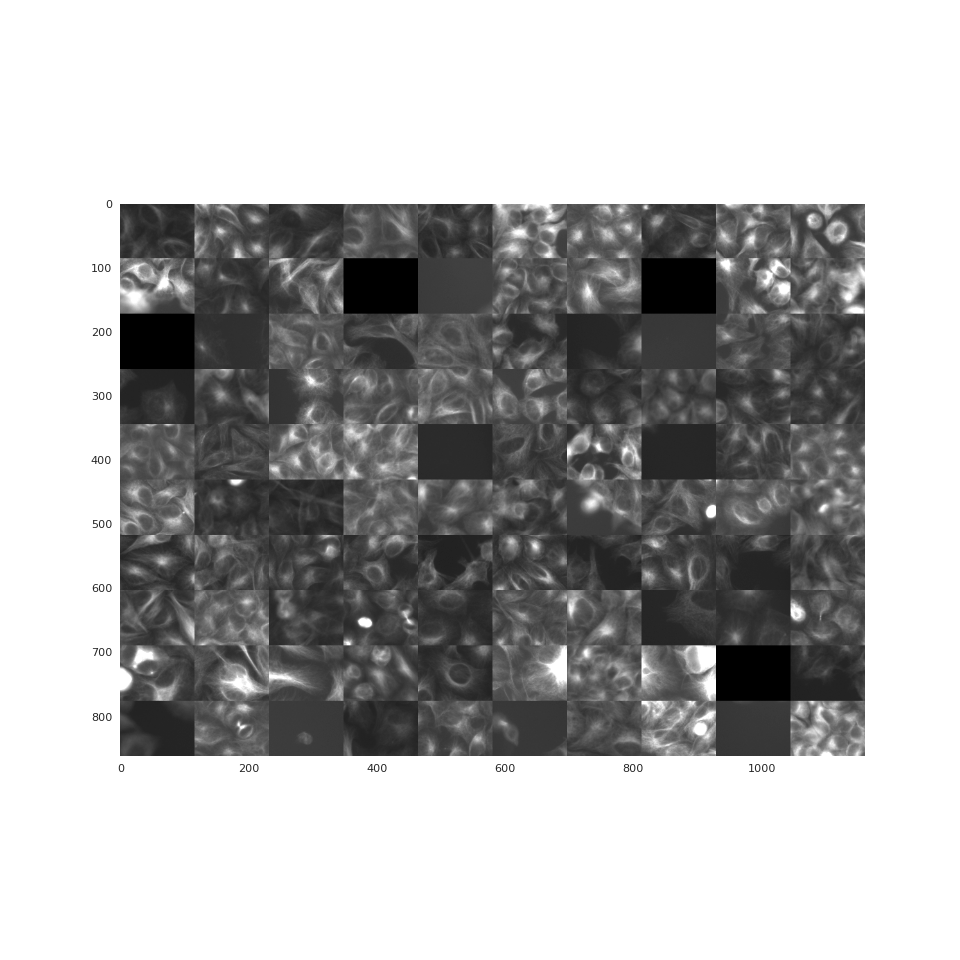

In [14]:
#a gallery of tiles for a bunch of phenotypes

conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
connected = conn.connect()

#ph=25
X=[  0, 580, 116, 348, 232, 464]
Y=[  0, 348,  87, 174, 261]
ni=10
w=116
h=86
phs=range(20,30)
tiles=np.zeros((h,w,len(phs)*ni))
for ph,kk in zip(phs,range(len(phs))):
    #print ph
    ws=dfRhonAnn[dfRhonAnn['BoolPhenotype '+str(ph)]].Well
    for ii in range(ni):
        we=random.choice(ws.values)
        we=conn.getObject('Well',we)
        i=we.getImage()   
        x=random.choice(X)
        y=random.choice(Y)
        #print x,y,w,h,i.getId()
        try:
            tiles[:,:,ii+kk*ni] =getRohnTile(i.getId(),x,y,w,h,chan=1)
        except:
            continue

plt.figure(figsize=(12,12))
imc=buildComposite(tiles,len(phs),ni)
plt.grid(False)
plt.imshow(imc)
    

## Stuff

In [8]:
pln='Plate10_Actinome1'
s2w[(s2w.PLATE==pln)].iloc[9].annotations

"{'siRNA Catalog Number': 'D-007290-01', 'Gene Identifier URL': 'http://www.ncbi.nlm.nih.gov/nuccore/NM_005470', 'siRNA Pool Name': 'ABI1', 'siRNA Identifier': 'ABI1-01', 'Gene Identifier': 'NM_005470'}"